# **Background**

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of different challenges including:

*   Identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
*   Testing your ability to generate code for a specified problem.
*   An opportunity for you to attempt an optional challenge question that extends the original problem set.

These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources (can be run in this colab).

Good luck!

**How to Use and Submit this Document?**

*   **Make a copy of this document** and rename it **Firstname_Lastname_C4AIScholarsChallenge**
*   Once you have completed all tasks, save and pin your revisions
*   Submit the assignment by responding directly to the email you received (please reply all) with a link to your final document by Friday September 29th at 12pm PDT.

# **Universal sentence embeddings background [2 points]**
In this takehome, we will be exploring different ways of learning sentence embeddings. Sentence embedding is the collective name for a set of techniques in natural language processing (NLP) where sentences are mapped to vectors of real numbers. For an overview of sentence embeddings and some common methods, we refer these articles: [link1](https://txt.cohere.com/sentence-word-embeddings/), [link2](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a)  

Q1: What are some real world applications of dense sentence embeddings?

Answer: Sentence embeddings are great for multiple NLP tasks, such as information retrieval and text classification, for instance. They can be used
for identifying spams in emails, classify text authors, emotion and sentiment analysis (which is useful in customer satisfaction
analysis), clustering news topics for finding related news.

Q2: Apart from using large language models, what are other ways to compute sentence embeddings?

Answer: The classical NLP methods represented words numerically by utilizing a meticulous preprocessing step
considering the entire corpus and obtained one-hot word
vectors, where each word is mapped to a unique position in a fixed length dimension. The words one-hot vectors can be aggregated by sum, for instance, thus obtaining a sentence vector.
TF-IDF is a efficient approach from classical NLP that leverage the count of words in a given corpus for encoding the word vectors, where the importances of frequent words in the document
are scaled down when representing them as vectors, that is, the one-hot encoded word vector was multiplied by a scalar that measured its frequency. Those methods are still relevant nowadays and heavily used in industry due to its simplicity of implementation, efficiency
and performance. For a classification task we can utilize a classification model on TF-IDF vectors and as result obtain comparable performance in simple problems,
when comparing to embeddings from language models based on neural networks (https://repositorio.comillas.edu/xmlui/bitstream/handle/11531/66166/submission4.pdf?sequence=1).

After advances in NLP new methods were created, based on learning words embeddings through an objective optimization and/or statistical/mathematical processes. Word2Vec uses a shallow neural network for learning word representations. Glove, in other hand, used matrix factorization for obtaining word embeddings.
Those methods obtained word embeddings by predicting a masked word given the words that sorrounded it in a window (Continuous bag of words) or by predicting the coherent context words
for that word (skip gram).
One of the major limitation of those models is that the words embeddings does not depends on its context, that is, each word is always mapped to the same point in the vector space, thus if there is ambiguity in a word meaning in a sentence it is not perceived by the model. Sentence embeddings can be obtained with Word2Vec and Glove by reducing the word embeddings in the sentences, usually by simple mean. In addition, the training proccess for those methods, more specific Word2Vec, is computing demanding and there are few parallelization possibilities, difficulting scaling in terms of data and model complexity.

The newer methods, for representing sentences in an embedding-fashion, are called universal sentence embeddings.
Firstly, those methods used a different unsupervised objective: instead of training for predicting individual words, they were trained to predict sorrounding
sentences. They rely on recursive neural networks, such as RNNs and LSTMs.
One of the first sucessful models trained in a supervised objective, InferSent, utilized a Natural Language Inference dataset,
where given a tuple of sentences the model had to classify them as neutral, contradiction or entailment. The sucess of this proposition
raised the question of which task could yield the best sentences embeddings that could be used outside the training context effectively.
The adopted solution for this questions was to combine multiple tasks at training time.

Apart from the refined training objective the neural networks based models used for obtaining sentence embeddings changed over time.
Prior to transformer-based LMs, RNN and LSTMs based models were used for obtaining sentence embeddings.
With those there were few parallelization opportunities. Given that, they suffered from a slow inference and training time. Also there are other common problems in recursive neural networks, for example, the training is unstable and can present vanishing or exploding gradients.

More recently Convolutional neural networks have been compared to Transformers (https://arxiv.org/pdf/2105.03322.pdf) in NLP tasks, and could outperform it in some scenarios.
Currently the Transformers architecture has been adopted as the general choice for multiple NLP tasks. They are scalable in terms
of model complexity and data, presents capability for parellel execution and stable gradients in training. Still, there are problems regarding this architecture, since one
of the major operations that compose the architecture is quadratic (softmax), there is a solution that proposes an approximation for softmax with linear complexity (https://arxiv.org/pdf/2009.14794.pdf) but it is not yet widely adopted.



**Imports**

In [ ]:
%pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/s eta 0:00:00


In [ ]:
import json
import math
from collections import OrderedDict
import torch
from torch import nn, Tensor
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import AdamW
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
import numpy as np
import gzip, csv
import pandas as pd
from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)

## **Coding Challenge Part 1: Debugging custom BERT code [8 points]**

BERT ([Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)) is a transformer based language model that is pretrained to generate contextualized embeddings. In this part, we provide a BERT implementation together with a pretrained checkpoint file. This BERT implementation includes 8 bugs in which some of these bugs break the code but some of them only impact the model performance.

Tasks:
* [**7 points**] Your goal is to get the code working. There are 7 bugs in the code, some of them lead to error in the code but some of them are designed to impair test accuracy but not break the code. You will one point for each of the 8 bugs you find.

* [**1 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs.


Note for usage and comparison:
*   In order to test this implementation, we provide ***bert_tiny.bin*** and example usage in the below cells.
*   You can check if your bugfixes are correct based on your results in "Coding challenge Part 2". Except the Bert imlementation, there is no bugs in other parts, so if your fixes are correct you should achieve the same results. We provide the expected results for you to compare.


**Please DO NOT use any additional library except the ones that are imported!!**

In [ ]:
# GELU Activation function
def gelu(x):
    """
    GELU is a nonlinear activation function. Nonlinear activations are required
    for neural networks approximate most of real world problems (which solutions does not
    have only linear relationships with the variables). The GELU is a recent proposition that
    worked better with transformers models when comparing to simpler activation functions,
    such as RELU, defined by the function: RELU(x) = max(x, 0). We can say that GELU
    is more smoother than RELU and thus can approximate
    complex functions easier than RELU (https://arxiv.org/pdf/1606.08415.pdf#page=6). The GELU defined
    by: GELU(x) = x * P(X <= x), where X is random variable from a Normal distribution with zero mean
    and variance 1 and P(.) is the probability of the event happening. It can be implemented
    as below using the gaussian error function (https://alaaalatif.github.io/2019-04-11-gelu/).
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class Config(object):
    def __init__(self,
                vocab_size: int,
                hidden_size: int = 768,
                num_hidden_layers: int = 12,
                num_attention_heads: int = 12,
                intermediate_size: int = 3072,
                dropout_prob: float = 0.1, # I aint sure if this can be considered a bug, but setting to 0.9 impairs the results significantly
                max_position_embeddings: int = 512,
                type_vocab_size: int = 2,
                initializer_range: float = 0.02) -> object:

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range
    """
    Load multiple hyperparameters, for initializing a BERT model.

    Args:
        vocab_size (int): Number of different tokens supported by the model
        hidden_size (int): Dimension of most of linear transformations inside the model
        num_hidden_layers (int): Number of Transformer Encoder Layers
        num_attention_heads (int): Number of heads inside a Transformer encoder Layer
        (hidden_size must be divisible by this number). Intuition: Multiple heads should
        capture different aspects of our sequence, and leverage those aspects when creating
        a representation.
        intermediate_size (int): Dimension of Fully Connected Neural Network block hidden layer.
        In summar the output of the Multihead attention will be projected at a wider dimensional
        space before be projected again to the hidden layer size. This size is usually higher than
        hidden_size, as the goal is to explore and connect the information outputed by the Multihead
        attention and project back to the original size, for being able to stack multiple transformer
        layers at a reasonable efficient dimension.
        dropout_prob (float): Probability of dropping activations randomly, in training.
        The dropout has a regularization effect as it explores different topologies of the neural
        network structure avoiding the homogeinity of predictions, in respect of used features and/or weights.
        It has roots on bayesian statistics. Higher values means stronger regularization effect.
        max_position_embeddings (int): Size of maximum supported sequence length.
        type_vocab_size (int): Number of possibles token type ids, used to differentiate multiple sentences
        when combining them in a single sequence.
        initializer_range (float): Initialization range of weight values of Linear transformations.
    Returns:
        object: The object instance with the defined parameters.
    """
    @classmethod
    def from_dict(cls, dict_object):
        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config


class LayerNorm(nn.Module):

      def __init__(self, hidden_size, variance_epsilon=1e-12):
        """
        Layer normalization apply a standardization in inputs followed by a linear transformation,
        disregarding batch information. In this, each input word representation is normalized individually.
        It was inspired in Batch normalization, that was widely used and effective in convolutional neural networks
        for visual tasks, bringing stability and faster convergence. For working at inference time, batch norm, had to store a running mean
        and running variance obtained from training batches to normalize inference instances.
        For NLP tasks, however, batch normalization does not work well, as the inputs lengths in a batch are not constant,
        the normalization would not be stable across different batches. As solution, Layer Norm was proposed and works well alongside Transformer-based
        language models.
        Variance epsilon is used to avoid zero division during the standardization.
        """
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

      def forward(self, x):
        """
        BUG 1: For performing the standardization we do not want to use batch information,
        to not modify inferences results according to batch information. Thus, we want to
        use the last axis of the tensor to standardization, that refers to individual token
        representation embedding.
        """
        u = x.mean(-1, keepdim=True) # desired dim of norm
        """
        BUG 2: This normalization method aims to transform the distribution of embeddings into
        a Normal(mean: 0, standard deviation: 1) distribution. Therefore, we need to subtract
        the mean and divide by the standard deviation for obtaining this distribution,
        instead of adding the mean.
        """
        s = (x - u).pow(2).mean(-1, keepdim=True) # subtract mean and verify axis
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta


class MLP(nn.Module):
      def __init__(self, hidden_size, intermediate_size):
        """
        Multilayer perceptron/Fully connected Neural network, it is the last operation in the Transformer
        architecture and project the merged heads outputs in a wider space, followed by a nonlinear
        activation function and linear transforms the tensor back to the original dimension. In a superficial view, this operation
        aims to capture complex information between the attention output and condense it back in a format suitable for the next encoder layers.
        The real role of this neural network module in Transformers is still in investigation, a work suggest that it helps to held memory from the initial inputs
        and outputs and propagate shallow knowledge obtained in those layers, throughout the encoder layers,
        combining simple and complex information regarding the input sequence, to the final encoder layers. (https://aclanthology.org/2021.emnlp-main.446.pdf).
        """
        super(MLP, self).__init__()
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

      def forward(self, x):
        x = self.dense_expansion(x)
        x = self.dense_contraction(gelu(x))
        return x


class Layer(nn.Module):
    def __init__(self, config):
        """
        Transformer Encoder Layer
        """
        super(Layer, self).__init__()

        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        self.ln1 = LayerNorm(config.hidden_size)

        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)

    def split_heads(self, tensor, num_heads, attention_head_size):
        """
        The Multihead self-attention weight matrices in a Transformer encoder layer are represented by a single weight
        matrix for each component: Query, Key and Value weights. That way we can compute a single matrix
        multiplication to acquire the outputs for every head in respect to the input. the output tensor,
        then is reshaped into the logical format, where each attention head have dimension equal
        hidden_size // number_of_heads.
        """
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)

    def merge_heads(self, tensor, num_heads, attention_head_size):
        """
        After the scaled dot-product attention, we should "concatenate" the heads again
        in a single dimension, as the following linear transformations
        and encoder layers will require this format to perform single matrix multiplications instead of one per head.
        """
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        """
        BUG 3: Missing the * for utilizing the multiple arguments of the new shape.
        """
        return tensor.view(*new_shape)

    def attn(self, q, k, v, attention_mask):
        """
        Scaled dot-product attention, this function is the core of Transformers architectures.
        Given the query, key and value tensors, splitted by heads, this function will perform
        a scaled dot-product attention operation of the sequence and map it to the model vocabulary.
        The attention operation aim`s to learn the relationships between the elements of two given sequences.
        As in this NLP Task we want to learn the relationship between elements of the same sequence, we will
        perform a self-attention operation.

        The use of multiple heads instead of computing only one attention weight, in the NLP context,
        should capture different type of relationships between the elements in the sequence and obtain richer representations.
        We can trace a parallel between heads in transformers and kernels in CNNs. In a 2D convolutional layer, with many kernels,
        from a CNN classifier each kernel learns a pattern to identify in a image,
        if there is a match between patterns a higher signal will be propagated. Thus, we can say that multiple heads should help to
        learn different semantics/relationships between words in a sentence.

        Firstly we perform a matrix multiplication between the queries and the transposed keys heads, this is necessary
        as they have the same shape. This operation can lead to large elements, in magnitude, in the result tensors
        which would impair the following steps and training stability, thus we scale those values by the square root
        of the attention heads dimensions.
        Then we use the softmax function to obtain probabilities of the words relationships, for each token representation.
        This operation helps to maintain the stability in training process and produce reliable inferences.

        However, for combining multiple sequences with variable lengths in a single tensor, we truncate or pad each
        sequence into a fixed length defined in the sentence tokenizer. In result smaller sequences then the max supported
        length will have unmeaningful positions, resulted from padding, that we do not want to attend.
        Therefore, before obtaining the probabilities using softmax, we utilize a attention mask to replace the
        scores from positions that were padded to an arbitrarily small number. That way, when applying softmax to the relationships
        scores for each element in the sequence, the attention weights that refer to padded tokens should be near zero.

        Finally, we use the probabilities/attention weights to obtain a hidden state for each element in the sequence,
        by using a weighted average with the attention output of a element as weights and the elements hidden states as values.
        For doing so, we perform matrix multiplication between the attention weights and the values matricies.
        Being A the attention weights matrix from a head and H the elements current hidden states,
        the new hidden state for the ith element will be:

        H_i = A_i @ H
        """
        mask = attention_mask == 1
        mask = mask.unsqueeze(1).unsqueeze(2)

        """
        BUG 4: Query and Key tensors have the same shape, for performing the Tensor multiplication
        of query and key heads and obtain attention scores it is necessary to transpose the key tensor.
        """
        s = torch.matmul(q, k.transpose(-1, -2))
        s = s / math.sqrt(self.attention_head_size)

        """
        BUG 5: For ignoring masked tokens when computing the attention weights using softmax, we can
        define an arbitrarily low value for those. Thus the probabilities computed by softmax operations
        for those tokens will be negligible.
        """
        s = torch.where(mask, s, torch.tensor(float('-inf')))

        """
        BUG 6: Missing the softmax function that computes probabilities (float numbers ranged from 0 to 1, by definition).
        Without this operation the scores ranges are unlimited which can hurt stability in training and inference.
        """
        p = F.softmax(s, dim=-1)
        p = self.dropout(p)

        a = torch.matmul(p, v)
        return a

    def forward(self, x, attention_mask):
        q, k, v = self.query(x), self.key(x), self.value(x)

        q = self.split_heads(q, self.num_attention_heads, self.attention_head_size)
        k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)
        a = self.attn(q, k, v, attention_mask)
        a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size)
        a = self.attn_out(a)
        a = self.dropout(a)

        """
        BUG 7: Missing the residuals of inputs to operation. For preserving previous signals from layers and operations
        and avoid vanishing gradients in deep neural networks, we can add the input information before layer normalization.
        This way we can propagate signals across deeper neural networks. It has roots on residual neural networks, such as ResNet.
        """
        a = self.ln1(a + x)

        m = self.mlp(a)
        m = self.dropout(m)
        m = self.ln2(a + m)

        return m

"""
This Bert model operates as follows:
The initial embeddings for a token are obtained by selecting a row from a matrix with dimensions (vocab_size, hidden_size),
each token id correspond to a row index in that matrix. The position embeddings are used to provide position information
to the token embedding and can be learned at training time. In the original Transformers those embeddings were derived from sine and cosine
functions without any learning applied to those embeddings. When combining multiple sentences the token type embeddings are used
for differentiate one sentence from another. Those embeddings are summed to compute the final token embedding, containing vocabulary,
position and sentence informations.

As explained above the token embeddings are feed into the transform encoder layers were the output from a transformer layer is the input
of the next layer. The final transform encoder output can be pooled to obtain a sentence representation for the downstream task,
the average of the token embeddings or linear transformation yield good results for sentence representation.
"""
class Bert(nn.Module):
      def __init__(self, config_dict):
        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.embeddings = nn.ModuleDict({
          'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
          'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
          'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)

        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

      def forward(self, input_ids, attention_mask=None, token_type_ids=None, ):
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        """
        BUG 8: When joining different token embeddings we need to reduce the final embeddings to the original
        defined hidden size for combining those informations. Commonly, we simply add the different embeddings.
        """
        #x = torch.cat((self.embeddings.token(input_ids),
        #               self.embeddings.position(position_ids),
        #               self.embeddings.token_type(token_type_ids)),
        #              dim=-1) # concatenating embeddings instead of sum (or another reduce method)

        x = self.embeddings.token(input_ids) + self.embeddings.position(position_ids) + self.embeddings.token_type(token_type_ids)
        x = self.ln(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, attention_mask)

        o = self.pooler(x[:, 0])
        return (x, o)

      def load_model(self, path):
        self.load_state_dict(torch.load(path))
        return self

**Download weights for the custom Bert**

In [ ]:
!wget https://github.com/for-ai/bert/raw/master/bert_tiny.bin

--2023-09-27 18:36:38--  https://github.com/for-ai/bert/raw/master/bert_tiny.bin
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin [following]
--2023-09-27 18:36:38--  https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17555010 (17M) [application/octet-stream]
Saving to: ‘bert_tiny.bin’

bert_tiny.bin       100%[===================>]  16.74M  --.-KB/s    in 0.06s   

2023-09-27 18:36:40 (273 MB/s) - ‘bert_tiny.bin’ saved [17555010/17555010]



**An example use of pretrained BERT with transformers library to encode a sentence**

In [ ]:
from transformers import AutoTokenizer, AutoModel # missing import
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## IF YOU CANNOT SOLVE PREVIOUS BUGS, USE THE LINE BELOW:
## bert = AutoModel.from_pretrained(MODEL_NAME)

bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#EXAMPLE USE
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output = bert(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

# We use "pooler_output" for simplicity. This corresponds the last layer
# hidden-state of the first token of the sequence (CLS token) after
# further processing through the layers used for the auxiliary pretraining task.
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')


Resulting embedding shape: torch.Size([1, 128])


In [ ]:
bert_from_pretrained = AutoModel.from_pretrained(MODEL_NAME)
bert_from_pretrained.eval()

sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output_from_pretrained = bert_from_pretrained(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

In [ ]:
bert_my_implementation = Bert(bert_config).load_model('bert_tiny.bin')
bert_my_implementation.eval()

sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output_my_implementation = bert_my_implementation(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

In [ ]:
## Outputs are different depending of the model

In [ ]:
(output_from_pretrained[-1] == output_my_implementation[-1]).all()

tensor(False)

In [ ]:
## In the example below of the embedding of the same sentence by both models, the differences were negligible.
## They may be due to floating point uncertainties, library versions or functions implementations between the models.

In [ ]:
output_from_pretrained[-1].round(decimals=5) - output_my_implementation[-1].round(decimals=5)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -9.9838e-06,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0014e-05,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.

In [ ]:
(output_from_pretrained[-1] - output_my_implementation[-1]).abs().mean()

tensor(1.2489e-07, grad_fn=<MeanBackward0>)

# **Coding Challenge Part 2: Evaluate a pretrained BERT model on STS benchmark [4 points]**

**Please do not use additional library except the ones that are imported!!**

In this part, we are going to evaluate a pretrained BERT model on STS benchmark without applying any additional training. For the evaluation we provide Pearson/Spearman correlation functions and cosine similarity method.

Tasks:

*   **[2 Points]** Prepare an evaluation data loader and evaluation loop: Read in the STS data, tokenize it as shown in the example,  generate the dataloader and return Pearson and Spearman correlation scores.
*   **[1 Point]** Implement cosine similarity function, explained as TODO

**[1 Point] Question**: What is the difference between Pearson and Spearman correlation, and why you might want to evaluate using both metrics?

Answer: Pearson Correlation directly obtain the linear correlation from values by dividing the covariance from two values by its individual variances, while Spearman ranks the values from each variable, before computing the pearson correlation. In result, Spearman can capture monotonic, non-linear, relationships between two variables. Combining those two metrics we can obtain a wider summary of our model performance, that considers outliers presences (Pearson pitfall as it measures only linear relationships a single outlier in the two given samples can change the Pearson correlation abruptly) and imbalanced datasets (Spearman pitfall, as spearman ranks variables if there is a large value gap between two ranks a lot of information was lost and Spearman can not identify a relationship, this usually happens in imbalanced data where the correlation can only be identified in a smaller portion of the minor group). That's said pearson and spearman correlations can be used together to address each one pitfalls. Considering many metrics is crucial for performing a robust evaluation.

**Semantic Textual Similarity (STS) benchmark:**
STS dataset consists of a set of sentence pairs with a semantic similarity scores for each pair. We want to use this dataset to evaluate the quality of a sentence encoder.

Dataset includes:

*   Sentence pair: (sentence1, sentence2)
*   Similarity score: ranging 1 to 5 where 5 corresponds highest similarity
*   Splits: train, dev, test

**Download datasets**

In [ ]:
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

--2023-09-27 18:36:45--  https://sbert.net/datasets/stsbenchmark.tsv.gz
Resolving sbert.net (sbert.net)... 188.114.97.0, 188.114.96.0, 2a06:98c1:3121::, ...
Connecting to sbert.net (sbert.net)|188.114.97.0|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz [following]
--2023-09-27 18:36:45--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392336 (383K) [application/octet-stream]
Saving to: ‘stsbenchmark.tsv.gz’

stsbenchmark.tsv.gz 100%[===================>] 383.14K  --.-KB/s    in 0.04s   

2023-09-27 18

In [ ]:
data = pd.read_csv('stsbenchmark.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [ ]:
def load_sts_dataset(file_name):
    #TODO: add code to load STS dataset in required format
    df = pd.read_csv(file_name, compression='gzip', delimiter='\t', encoding='utf-8', quoting=3)

    def get_all_splits(df, split):
        return df[df["split"] == split].reset_index(drop=True)
    splits = ["dev", "test"]
    df_splits = [get_all_splits(df, s) for s in splits]

    sts_samples = {split_name: {"sent1": df_split["sentence1"].astype(str).values.tolist(), "sent2": df_split["sentence2"].astype(str).values.tolist(),
                              "score": df_split["score"].tolist()}
                 for split_name, df_split in zip(splits, df_splits)}
    return sts_samples


def tokenize_sentence_pair_dataset(dataset, tokenizer, max_length=512):
    #TODO: add code to generate tokenized version of the dataset
    tokenized_sent1 = tokenizer(dataset["sent1"], return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
    tokenized_sent2 = tokenizer(dataset["sent2"], return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)

    tokenized_dataset = [
    {"input_ids_1": in1, "att_mask_1": att1, "input_ids_2": in2, "att_mask_2": att2, "score": scr}
    for in1, att1, in2, att2, scr in zip(list(tokenized_sent1["input_ids"]), list(tokenized_sent1["attention_mask"]), list(tokenized_sent2["input_ids"]),
                      list(tokenized_sent2["attention_mask"]), list(torch.Tensor(dataset["score"])))
    ]
    return tokenized_dataset


def get_dataloader(tokenized_dataset, batch_size, shuffle=False):
    return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)

def cosine_sim(a, b):
    # TODO: Implement cosine similarity function **from scrach**:
    # This method should expect two 2D matrices (batch, vector_dim) and
    # return a 2D matrix (batch, batch) that contains all pairwise cosine similarities
    eps = 1e-8
    a_norm = a.norm(p=2, dim=-1)[:, None]
    b_norm = b.norm(p=2, dim=-1)[:, None]

    a_norm = torch.max(a_norm, eps * torch.ones_like(a_norm))
    b_norm = torch.max(b_norm, eps * torch.ones_like(b_norm))

    sim = torch.mm(a / a_norm, (b / b_norm).transpose(0, 1))
    return sim


def eval_loop(model, eval_dataloader, device):
    #TODO: add code to for evaluation loop
    #TODO: Use cosine_sim function above as distance metric for pearsonr and spearmanr functions that are imported
    # from scipy.stats import pearsonr, spearmanr
    model.eval()
    labels = []
    pair_wise_cosines = []
    for batch in eval_dataloader:
        with torch.no_grad():
            output_1 = model(input_ids=batch["input_ids_1"].to(device), attention_mask=batch["att_mask_1"].to(device))[1]
            output_2 = model(input_ids=batch["input_ids_2"].to(device), attention_mask=batch["att_mask_2"].to(device))[1]
            cos_sim = torch.diag(cosine_sim(output_1, output_2), diagonal=0).cpu().numpy()

        labels.append(list(batch["score"].cpu().numpy()))
        pair_wise_cosines.append(cos_sim)

    labels = np.concatenate(labels, axis=-1)
    pair_wise_cosines = np.concatenate(pair_wise_cosines, axis=-1)
    return [pearsonr(x=pair_wise_cosines, y=labels).statistic, spearmanr(a=pair_wise_cosines, b=labels).statistic]

**Evaluation**

Expected result:

Pearson correlation: 0.32

Spearman correlation: 0.33

In [ ]:
#INFO: model and tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#INFO: load bert
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#INFO: load dataset
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

#INFO: tokenize dataset
tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)

#INFO: generate dataloader
test_dataloader = get_dataloader(tokenized_test, batch_size=128)

#INFO: run evaluation loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
bert = bert.to(device)
results_from_pretrained = eval_loop(bert, test_dataloader, device)

print(f'\nPearson correlation: {results_from_pretrained[0]:.2f}\nSpearman correlation: {results_from_pretrained[1]:.2f}')


Pearson correlation: 0.32
Spearman correlation: 0.33


# **Coding Challenge Part 3: Learning sentence embeddings using Natural Language Inference (NLI) dataset [4 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

[Conneue et al. (2018)](https://https://arxiv.org/pdf/1705.02364.pdf) showed that a good sentence embedding model can be learned using NLI dataset. This method proposes using a shared encoder to encode both premise and hypothesis and then combine them before using a softmax classifier. Here , we will use a pretrained BERT model as shared encoder.  

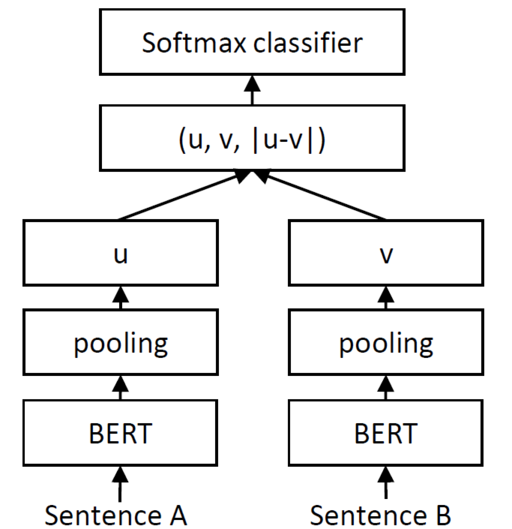

Tasks:

*   **[2 Point]** Prepare a training dataloader and training loop: Read in NLI data, tokenize and generate the corresponding data loader
*   **[2 Point]** BertClassifier: Construct a model that uses above method

**Download NLI dataset**

This dataset includes:
*   Sentence pairs: (sentence1, sentence2)
*   Label: (contradiction, entailment, neutral)
*   Split: train, dev, test

In [ ]:
!wget 'https://sbert.net/datasets/AllNLI.tsv.gz'

--2023-09-27 18:36:59--  https://sbert.net/datasets/AllNLI.tsv.gz
Resolving sbert.net (sbert.net)... 188.114.97.0, 188.114.96.0, 2a06:98c1:3121::, ...
Connecting to sbert.net (sbert.net)|188.114.97.0|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz [following]
--2023-09-27 18:36:59--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40794454 (39M) [application/octet-stream]
Saving to: ‘AllNLI.tsv.gz’

AllNLI.tsv.gz       100%[===================>]  38.90M   180MB/s    in 0.2s    

2023-09-27 18:36:59 (180 MB/s) - ‘Al

In [ ]:
data = pd.read_csv('AllNLI.tsv.gz', compression='gzip', delimiter='\t', encoding='utf-8', quoting=3)
data.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


In [ ]:
data["split"].unique()

array(['train', 'dev', 'test'], dtype=object)

In [ ]:
def load_nli_dataset(file_name, train_sample_size=None, splits=["train"]):
    #TODO: add code to load NLI dataset in required format
    df = pd.read_csv(file_name, compression='gzip', delimiter='\t', encoding='utf-8', quoting=3)

    def get_all_splits(df, split):
        if split != "train" or train_sample_size == None:
            return df[df["split"] == split].reset_index(drop=True)
        else:
            return df[df["split"] == split].head(train_sample_size).reset_index(drop=True)

    df_splits = [get_all_splits(df, s) for s in splits]

    labels_dict = {
      "contradiction": 0,
      "neutral": 1,
      "entailment": 2,
    }
    nli_samples = {split_name: {"sent1": df_split["sentence1"].astype(str).values.tolist(), "sent2": df_split["sentence2"].astype(str).values.tolist(),
                              "score": df_split["label"].apply(lambda x: labels_dict[x]).tolist()}
                 for split_name, df_split in zip(splits, df_splits)}
    return nli_samples

# A periodic eval on dev test can be added (validation_dataloader)
def train_loop(model, optimizer, train_dataloader, validation_dataloader, num_epochs, device):
    #TODO: add code to for training loop
    #TODO: use optimizer, train_dataloader, num_epoch and device for training
    for e in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch in train_dataloader:
            _, loss = model(input_ids_1=batch["input_ids_1"].to(device),
                                attention_mask_1=batch["att_mask_1"].to(device),
                                input_ids_2=batch["input_ids_2"].to(device),
                                attention_mask_2=batch["att_mask_2"].to(device),
                                targets=batch["score"].long().to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            epoch_loss += loss.item()

        pearson, spearman = eval_loop(model.encoder, validation_dataloader, device)
        print(f"Epoch {e + 1} - training loss: {epoch_loss/len(train_dataloader)} - pearson corr val: {pearson} - spearman corr val: {spearman}")

class BertClassifier(nn.Module):
    #TODO: add __init__ to construct BERTClassifier based on given pretrained BERT
    #TODO: add code for forward pass that returns the loss value
    #TODO: add aditional method if required
    def __init__(self, encoder, num_labels, encoder_out_dim=128, hidden_layer_dim=128, dropout_rate=0.1):
        super(BertClassifier, self).__init__()
        self.encoder = encoder
        self.mlp = nn.Sequential(nn.Linear(3 * encoder_out_dim, hidden_layer_dim), nn.GELU(), nn.Dropout(p=dropout_rate), nn.Linear(hidden_layer_dim, num_labels))

    def forward(self, input_ids_1, attention_mask_1, input_ids_2, attention_mask_2, targets=None):
        encoded_1 = self.encoder(input_ids=input_ids_1, attention_mask=attention_mask_1)[1]
        encoded_2 = self.encoder(input_ids=input_ids_2, attention_mask=attention_mask_2)[1]

        scores = self.mlp(torch.cat([encoded_1, encoded_2, (encoded_1-encoded_2).abs()], dim=-1))
        if self.training:
            assert targets != None
            return scores, nn.CrossEntropyLoss()(scores, targets)
        else:
            return scores, None

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz', train_sample_size=50000)

assert (nli_dataset['train']['sent1'] == data.head(50000)["sentence1"]).all()
assert (nli_dataset['train']['sent2'] == data.head(50000)["sentence2"]).all()
#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence length of 128 # moved for above for compatibility
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)

#TODO: Create a BertClassifier with required parameters
###    Replace None with required input based on yor implementation
bert = Bert(bert_config).load_model(bert_path)
bert_classifier = BertClassifier(bert, num_labels, encoder_out_dim=bert_config["hidden_size"], hidden_layer_dim=bert_config["hidden_size"], dropout_rate=0.1)
bert_classifier = bert_classifier.to(device)
#INFO: create optimizer and run training loop
# Here we could skip regularization for bias parameters as they are not sensitive to input
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)

tokenized_dev = tokenize_sentence_pair_dataset(sts_dataset['dev'], tokenizer)
dev_dataloader = get_dataloader(tokenized_dev, batch_size=batch_size, shuffle=True)

train_loop(bert_classifier, optimizer, train_dataloader, dev_dataloader, num_epochs, device)

Epoch 1 - training loss: 0.9128674343848229 - pearson corr val: 0.45358254384745256 - spearman corr val: 0.5469182773864821
Epoch 2 - training loss: 0.7585239207148552 - pearson corr val: 0.5011896428968253 - spearman corr val: 0.5808182389071576
Epoch 3 - training loss: 0.6834103291225433 - pearson corr val: 0.5571731477198075 - spearman corr val: 0.6262673734749373


**Evaluation**

Expected result:

Pearson correlation: 0.37

Spearman correlation: 0.42

In [ ]:
result_from_classification = eval_loop(bert_classifier.encoder, test_dataloader, device)
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')


Pearson correlation: 0.53
Spearman correlation: 0.56


# **Coding Challenge Part 4: Learning sentence embedding using a contrastive approach based on NLI dataset [3 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

In this part, you are asked to explore another method that leverages a contrastive approach using NLI dataset.

Tasks **[3 Points]** :

*   Generate a dataloader if this is required for your approach
*   Construct a BERT based model using a contrastive method

In [ ]:
#TODO: add code to load NLI dataset in required format
###    if load_nli_dataset(..) is not appropriate for your method
# not required
class BertContrastive(nn.Module):
    #TODO: add __init__ to construct BertContrastive based on given pretrained BERT
    #TODO: add code for forward pass that returns the loss value
    #TODO: add aditional method if required
    def __init__(self, encoder, num_labels, encoder_out_dim=128, hidden_layer_dim=384, dropout_rate=0.1, margin_1=0.5, margin_2=0.05):
        super(BertContrastive, self).__init__()
        self.encoder = encoder
        self.mlp = nn.Sequential(nn.Linear(3 * encoder_out_dim, hidden_layer_dim), nn.GELU(), nn.Dropout(p=dropout_rate), nn.Linear(hidden_layer_dim, num_labels))
        self.margin_1 = margin_1
        self.margin_2 = margin_2

    def forward(self, input_ids_1, attention_mask_1, input_ids_2, attention_mask_2, targets=None):
        encoded_1 = self.encoder(input_ids=input_ids_1, attention_mask=attention_mask_1)[1]
        encoded_2 = self.encoder(input_ids=input_ids_2, attention_mask=attention_mask_2)[1]

        scores = self.mlp(torch.cat([encoded_1, encoded_2, (encoded_1-encoded_2).abs()], dim=-1))
        if self.training:
            assert targets != None

            # Cross entropy Loss
            loss = nn.CrossEntropyLoss()(scores, targets)

            # Compute cosine distance, could be other distance metric, but cosine similarity is robust to different norm vectors
            # that could interfer in the stability of training
            cosine_dists = 1.0 - torch.diag(cosine_sim(encoded_1, encoded_2), diagonal=0)

            # Contrast with positive and hard negative tuples
            targets_select = targets != 1

            # As I convenently defined the labels as such, we can transform the labels as below for obtaining 0 and 1s as labels
            targets_contrast = targets[targets_select] / 2
            dists_pos_and_hard_negative = cosine_dists[targets_select]

            """
            If target equals 1 the second half of the equation below is canceled and we
            minimize the cosine distance of the positive labels, approximating in the embedding space
            entailment pairs.

            If target equals 0 the first half of the equation is canceled and we depart the contradiction sentences
            pairs in the embedding space until a defined margin. That is, if the distance of the pairs
            in the embedding space is greater than the margin we dont learn on this instance.
            """
            if len(targets_contrast) > 0:
                loss_spc_1 = 0.5 * (targets_contrast.float() * dists_pos_and_hard_negative.pow(2)
                                    + (1 - targets_contrast).float() * torch.max(self.margin_1 - dists_pos_and_hard_negative, torch.zeros_like(dists_pos_and_hard_negative)).pow(2))
                loss += loss_spc_1.mean()


            """
            If a sentence pair relationship is neutral we could still choose to increase the distance between than
            but not as abruptly as if it the sentence pair is a contradiction. So if we consider pairs labeled as neutral
            as negative pairs we can apart then until a smaller margin than for contradiction pairs. That way, neutral
            pairs embeddings will be closer than contradictions but still far than positives.
            """
            targets_select_neutral = targets == 1
            if sum(targets_select_neutral) > 0:
                dists_negative = cosine_dists[targets_select_neutral]
                loss_spc_2 = 0.5 * (torch.max(self.margin_2 - dists_negative, torch.zeros_like(dists_negative)).pow(2))
                loss += loss_spc_2.mean()

            return scores, loss
        else:
            return scores, None

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
train_batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_nli_dataset('AllNLI.tsv.gz', train_sample_size=50000)

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'], tokenizer, max_length=128) # train data limit moved to function above

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=train_batch_size)

#TODO: Create a BertContrastive with required parameters
###    Replace None with required input based on yor implementation
bert = Bert(bert_config).load_model(bert_path)
bert_contrastive = BertContrastive(bert, num_labels, encoder_out_dim=bert_config["hidden_size"], hidden_layer_dim=bert_config["hidden_size"], dropout_rate=0.1)
bert_contrastive = bert_contrastive.to(device)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)

train_loop(bert_contrastive, optimizer, train_dataloader, dev_dataloader, num_epochs, device)

Epoch 1 - training loss: 0.9136582469630241 - pearson corr val: 0.5488295134128598 - spearman corr val: 0.6146460967716962
Epoch 2 - training loss: 0.7665744849014282 - pearson corr val: 0.5922792986210595 - spearman corr val: 0.6530421713119418
Epoch 3 - training loss: 0.6909196347057819 - pearson corr val: 0.6072883445981878 - spearman corr val: 0.6623266581463114


**Evaluation**

In [ ]:
#TODO: run evaluation loop
result_from_contrastive = eval_loop(bert_contrastive.encoder, test_dataloader, device)
print(f'\nPearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')


Pearson correlation: 0.57
Spearman correlation: 0.59


# **Coding Challenge Part 5: Comparison [1 Point]**

In the final part of the coding challenge, you are asked to compare the result of pretrained BERT, classification based BERT, and contrastive method based BERT.

These are the tasks **[1 Point]**:


*   Plot the result for each model
*   Explain the difference between methods and their impact on the result and comparison

In [ ]:
df_results = pd.DataFrame([{
    "method": "pretrained",
    "pearson": results_from_pretrained[0],
    "spearman": results_from_pretrained[1],
},
{
    "method": "classifier",
    "pearson": result_from_classification[0],
    "spearman": result_from_classification[1],
},
{
    "method": "contrastive",
    "pearson": result_from_contrastive[0],
    "spearman": result_from_contrastive[1],
}])

In [ ]:
df_results

,method,pearson,spearman
0,pretrained,0.316313,0.328326
1,classifier,0.528940,0.555070
2,contrastive,0.572815,0.587617


On the chart below we can see the performance of the methods in the two defined metrics.
As expected, the pretrained model performance was the worse among the models, as the two
other methods rely on extra training data and specific objectives to increase the quality of
sentence embeddings. This method is usually used as a checkpoint to fine-tune for a specific
downstream task as we did in this challenge. The model trained for classifying a NLI task performed
much better in sentence similarity. Altought the NLI classification task helps to differentiate sentences in the vector space,
for performing well in sentence similarity tasks it may be beneficial to enforce a well-defined
embedding space for projecting sentences, in which different points can be discriminated by a distance
metric, for instance.

In this regard the addition of a contrastive learning objective aims to focus on the positive (entailment) and hard negative
(contradiction) instances. By adding this method we explicit maximize, given a distance metric, the distance of the embeddings representations
in the embedding space, between sentences that contradict and minimize the distance of sentences representations that entail. This method
helps to untangle the sentences in the embedding space.
I considered neutral pairs as soft negatives and aparted them in the space by a smaller margin than for contradictions.
Combining contrastive learning with the softmax classifier increased the performance in both metrics by a considerable margin, which
demonstrate the importance of contrastive learning in obtaining good embedding representations for sentences in this context.
Altought I did not utilize extra learnable parameters in training, the contrastive approach required extra computation.


<Axes: xlabel='method'>

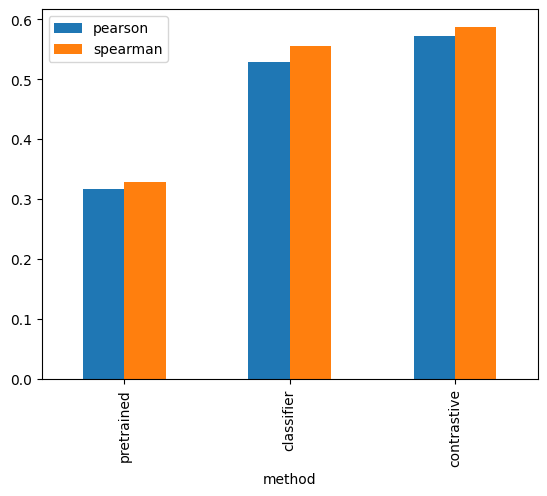

In [ ]:
df_results.plot.bar(x="method")

# **[OPTIONAL] Explore an alternative way to improve sentence encoder in terms of *performance* or *efficiency* [6 Points]**

Potential directions:
*   Improve the methodology to compute higher quality sentence embeddings  
*   Improve the efficiency during fine-tuning in terms of memory or training time
*   Use different machine learning methods that leverages other resources such as auxillary/teacher models
*   Use different datasets with other training objectives


**You can use any additional model, dataset, library or package for this part!!**

# Knowledge Distillation in multiple model outputs is a big part of what you need (obtaining better sentence embeddings in this small model)

As an alternative solution to this problem I proposed a Knowledge Distillation approach based on MiniLM V1 (https://proceedings.neurips.cc/paper/2020/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf), MiniLM V2(https://arxiv.org/pdf/2012.15828.pdf) and in training hyperparameters
settings in the results of this paper (https://arxiv.org/pdf/2105.08919.pdf).
In addition I proposed a different knowledge distillation objective, based on contrastive learning and a model hyperparameter recommendation regarding the methodology of MiniLMv2.

Apart from the teacher model, I will not rely on extra resources to execute my proposition. The student model itself will share the same pre-trained checkpoint and number of parameters as previous models in this challenge.

**Introduction**:
In summary, knowledge distillation consists in utilizing a pre-trained model named as teacher, to train a smaller model, named as student,
to mimic the teacher behavior. Usually we can use kullback leibler divergence (KLD) or Mean squared error (MSE) for minimizing the differences
between the student outputs and teacher outputs.

For each neural network architecture and task, there are a set of methods to train a better student model for mimicking the teacher behavior. A simple baseline consists in training the students to mimic the logits of the teacher in a classification task.

**Approach**:
Instead of mimicking the logits in a classification task, I choose to implement a specific solution for Knowledge distillation of transformer
models, in which the student model mimics scaled dot-products of combinations of the outputs from Query, Key and Value teacher matrices,
which are used to compute the attention weights and tokens hidden states in Transformers, this way the student should learn similar relationships, between words
in a sentence, to the teacher model.

For doing so, for each sequence we extract the query, key and value outputs of the last encoder layers from teacher and student models.
Then we split those matrices into heads. If those models have different number of heads they will have different
output shapes. Thus, instead of dividing the embeddings into the correspondent attention heads for each model, we divide the shape of each output by a same value, in MiniLM2 they are called relation heads.

In MiniLM2 it is stated that there is no restrictions for the number of
relation heads, altough the heads semantics can be lost in this process, in the experiments from their study the student model still could capture the general Teacher behavior.

However in my experiments, the best students preserved an approximation of the original heads structure from both models. For doing so, considering the following outputs dimensions and number of heads: $T_{dim}=384$, $T_h=12$ and $S_{dim}=128$, $S_h=8$, for Teacher and Student dimension and number of heads respectively, I selected a number of relation heads that would not truncate the original dimensions of the Teacher and student models heads, that are:

 $T_{h_{dim}} = T_{dim} / T_h = 32$ and $S_{h_{dim}} = S_{dim} / S_h = 16$.

Therefore, I utilized 4 relation heads, $R_h$. This way each relation head will contain information from 3 original heads of the Teacher model:

$3 * T_{h_{dim}} = T_{dim} / R_h = 96$

and 2 original heads of the student model:

$2 * S_{h_{dim}} = S_{dim} / R_h = 32$

Further research would be required to verify the best approach for defining the number of relation heads, but my intuition, considering my experiments results, is that truncating original heads information is hurtful, in this scenario, for the distillation process.

Given those settings, then we compute scaled_dot_products(.) between those tensors, for each model. The first MiniLM paper computed scaled_dot_products(Q, K) (equivalent of obtaining attention scores, if the original heads were preserved) and
scaled_dot_products(V, V). MiniLM2 utilizes self-attention dot products between each of Q, K and V. In my experiments, the impact
of adding an extra scaled_dot_products(.) was minor considering the overhead in computation, so I used the MiniLM V1 approach.
Then we compute the KLD with student dot products as input and teacher dot products as targets, both, inputs and targets, are transformed using log_softmax for training stability.

For performing KLD we utilize the following hyperparameters: temperature (a scalar that scales the outputs from scaled dot-product attention before log_softmax) and a cross entropy scale parameter
(for adjusting the weight of cross entropy and Knowledge Distil). I utilized hyperparameters based on the results from the third available paper, where
the authors conducted experiments where a low cross entropy weight and higher temperature achieved best results.

Finally, I added a new Knowledge Distillation objective, based on contrastive learning, that project the pooled output from the student model (if necessary) into the same dimension of the teacher model and minimizes the cosine distances between those embeddings for a same instance. In my approach I utilized a single linear transformation for projection.

In summary, apart from evaluating the results of knowledge distillation in the previously defined metrics, I will evaluate the proposals with my authorship, regarding the scenario of this project:

* Impact of the definition of the number of relation heads that truncate or not the output.
* Impact of minimizing the cosine distances of pooled outputs.

**Results and discussion are available in the final section.**


This simple teacher model is a result from a knowledge distillation and have only three encoder layers

In [ ]:
teacher_model_name = 'sentence-transformers/paraphrase-MiniLM-L3-v2'
teacher_model = AutoModel.from_pretrained(teacher_model_name).to(torch.device("cuda"))
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)

In [ ]:
#INFO: tokenize dataset
tokenized_test_teacher = tokenize_sentence_pair_dataset(sts_dataset['test'], teacher_tokenizer)
test_dataloader_teacher = get_dataloader(tokenized_test_teacher, batch_size=32)

As seen below, the results in sentence similarity for this teacher model are great when comparing to the previously tested models:

In [ ]:
result_from_teacher_model = eval_loop(teacher_model, test_dataloader_teacher, torch.device("cuda"))
print(f'\nPearson correlation: {result_from_teacher_model[0]:.2f}\nSpearman correlation: {result_from_teacher_model[1]:.2f}')


Pearson correlation: 0.77
Spearman correlation: 0.78


In [ ]:
# Used to extract Query, key and value output matrices from a transformer encoder layer
class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str):
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, input_ids: Tensor, attention_mask: Tensor):
        _ = self.model(input_ids, attention_mask)
        return self._features

class BertKD(nn.Module):
    def __init__(self, teacher, student, num_labels,
                 teacher_out_dim=384,
                 student_out_dim=128,
                 rel_att_heads=4,
                 hidden_layer_dim=384,
                 dropout_rate=0.1,
                 alpha=0.9,
                 temperature=100,
                 teacher_qkv_names=['encoder.layer.2.attention.self.query', 'encoder.layer.2.attention.self.key', 'encoder.layer.2.attention.self.value'],
                student_qkv_names=['layers.1.query', 'layers.1.key', 'layers.1.value'],
                use_contrastive=True):
        super(BertKD, self).__init__()
        """
        Above the last layer of query, key and value outputs of joined heads from teacher and
        student models were used as default parameters as I did not tested other
        scenarios to perform KD.
        """
        self.teacher = teacher
        self.student = student
        self.qkv_extractor_teacher = FeatureExtractor(self.teacher, layers=teacher_qkv_names)
        self.qkv_extractor_student = FeatureExtractor(self.student, layers=student_qkv_names)
        self.teacher_qkv_names = teacher_qkv_names
        self.student_qkv_names = student_qkv_names
        self.rel_att_heads = rel_att_heads
        self.student_out_dim = student_out_dim
        self.teacher_out_dim = teacher_out_dim
        self.mlp = nn.Sequential(nn.Linear(3 * student_out_dim, hidden_layer_dim), nn.GELU(), nn.Dropout(p=dropout_rate), nn.Linear(hidden_layer_dim, num_labels))
        # Dont use bias, as we will not use the translated projection for inference
        self.project_student = nn.Linear(student_out_dim, teacher_out_dim, bias=False)
        self.temperature = temperature
        self.use_contrastive = use_contrastive
        self.alpha = alpha

    def split_heads(self, tensor, num_heads, attention_head_size):
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)

    """
    I modified the scaled dot product to return the log softmax with temperature
    instead of only softmax. Using log softmax for input and target should be
    more stable in training then only softmax.
    """
    def scaled_dot_product(self, x, y, attention_mask, head_dim):
        eps = 1e-8
        mask = attention_mask == 1
        mask = mask.unsqueeze(1).unsqueeze(2)
        s = torch.matmul(x, y.transpose(-1, -2)) # (B x H x S x S)
        s = s / math.sqrt(head_dim)
        s = torch.where(mask, s, torch.tensor(float('-inf')))
        p = F.softmax(s / self.temperature, dim=-1)
        return torch.log(p + eps)

    def kld_loss(self, student_tensor, teacher_tensor):
        return F.kl_div(student_tensor, teacher_tensor, reduction="batchmean", log_target=True) * (self.temperature ** 2)

    """
    Return scaled dot-product relation heads for a given model feature extractor.
    """
    def get_scaled_dot_product(self, input_ids, attention_mask, feature_extractor, qkv_names, hidden_size, num_heads):
        query_name, key_name, value_name = qkv_names
        qkv = feature_extractor(input_ids=input_ids, attention_mask=attention_mask)

        head_dim = hidden_size // num_heads
        query = self.split_heads(qkv[query_name], num_heads, head_dim)
        key = self.split_heads(qkv[key_name], num_heads, head_dim)
        value = self.split_heads(qkv[value_name], num_heads, head_dim)

        scaled_dot_product_qk = self.scaled_dot_product(query, key, attention_mask, head_dim)
        scaled_dot_product_vv = self.scaled_dot_product(value, value, attention_mask, head_dim) # (B x H x S x S)
        return scaled_dot_product_qk, scaled_dot_product_vv

    def forward(self, input_student, input_teacher=None, targets=None):

        input_ids_1, attention_mask_1, input_ids_2, attention_mask_2 = input_student
        encoded_1 = self.student(input_ids=input_ids_1, attention_mask=attention_mask_1)[1]
        encoded_2 = self.student(input_ids=input_ids_2, attention_mask=attention_mask_2)[1]

        scores = self.mlp(torch.cat([encoded_1, encoded_2, (encoded_1-encoded_2).abs()], dim=-1))
        if self.training:
            assert targets != None and input_teacher != None
            # Gather Teacher model Relation Heads
            with torch.no_grad():
                input_ids_1, attention_mask_1, input_ids_2, attention_mask_2 = input_teacher

                teacher_qk_scaled_dot_1, teacher_vv_scaled_dot_1 = self.get_scaled_dot_product(input_ids_1, attention_mask_1,
                                                                                               self.qkv_extractor_teacher, self.teacher_qkv_names, self.teacher_out_dim, self.rel_att_heads)
                teacher_qk_scaled_dot_2, teacher_vv_scaled_dot_2 = self.get_scaled_dot_product(input_ids_2, attention_mask_2, self.qkv_extractor_teacher, self.teacher_qkv_names,
                                                                                               self.teacher_out_dim, self.rel_att_heads)
                teacher_qk_scaled_dot = torch.cat([teacher_qk_scaled_dot_1, teacher_qk_scaled_dot_2], dim=0)
                teacher_vv_scaled_dot = torch.cat([teacher_vv_scaled_dot_1, teacher_vv_scaled_dot_2], dim=0)

            # Gather Student model Relation Heads
            input_ids_1, attention_mask_1, input_ids_2, attention_mask_2 = input_student
            student_qk_scaled_dot_1, student_vv_scaled_dot_1 = self.get_scaled_dot_product(input_ids_1, attention_mask_1, self.qkv_extractor_student, self.student_qkv_names,
                                                                                           self.student_out_dim, self.rel_att_heads)
            student_qk_scaled_dot_2, student_vv_scaled_dot_2 = self.get_scaled_dot_product(input_ids_2, attention_mask_2, self.qkv_extractor_student, self.student_qkv_names,
                                                                                           self.student_out_dim, self.rel_att_heads)
            student_qk_scaled_dot = torch.cat([student_qk_scaled_dot_1, student_qk_scaled_dot_2], dim=0)
            student_vv_scaled_dot = torch.cat([student_vv_scaled_dot_1, student_vv_scaled_dot_2], dim=0)

            # Compute KLD with student relation heads as input and teacher relation heads as targets
            loss_kd_qk = self.kld_loss(student_qk_scaled_dot, teacher_qk_scaled_dot)
            loss_kd_vv = self.kld_loss(student_vv_scaled_dot, teacher_vv_scaled_dot)

            loss_kd_contrastive = 0.0
            # If enabled, minimize the distances between teacher and student models pooled outputs
            if self.use_contrastive:
                with torch.no_grad():
                    self.teacher.eval()
                    input_ids_1, attention_mask_1, input_ids_2, attention_mask_2 = input_teacher
                    encoded_1_teacher = self.teacher(input_ids=input_ids_1, attention_mask=attention_mask_1)[1]
                    encoded_2_teacher = self.teacher(input_ids=input_ids_2, attention_mask=attention_mask_2)[1]

                eps = 1e-8
                cosine_dists = 1.0 - torch.diag(cosine_sim(torch.cat([self.project_student(encoded_1), self.project_student(encoded_2)], dim=0),
                                                           torch.cat([encoded_1_teacher, encoded_2_teacher], dim=0)), diagonal=0)

                # higher self.temperature here will penalize the most distant pairs
                temperature_kd_contrastive = 1 / self.temperature
                loss_kd_contrastive = 0.5 * (cosine_dists / temperature_kd_contrastive).pow(2)
                loss_kd_contrastive = loss_kd_contrastive.mean()

            # Multiply KD losses by the defined importance
            loss = self.alpha * (loss_kd_qk + loss_kd_vv + loss_kd_contrastive)

            # Multiply Supervised loss by (1 - defined importance)
            loss += (1.0 - self.alpha) * nn.CrossEntropyLoss()(scores, targets)
            return scores, loss
        else:
            return scores, None

In [ ]:
"""
I modified training and tokenizer functions to add the possibility of using teacher
and students with different tokenizers, this would not be necessary for the
choosen Teacher and Student model, still I made the possibility available, for future endeavours
"""
def train_loop_knowledge_distil(model, optimizer, train_dataloader, validation_dataloader, num_epochs, device):
    for e in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for batch in train_dataloader:
            batch_student = [
                batch["input_ids_1_1"].to(device),
                batch["att_mask_1_1"].to(device),
                batch["input_ids_1_2"].to(device),
                batch["att_mask_1_2"].to(device),
            ]
            batch_teacher = [
                batch["input_ids_2_1"].to(device),
                batch["att_mask_2_1"].to(device),
                batch["input_ids_2_2"].to(device),
                batch["att_mask_2_2"].to(device),
            ]
            _, loss = model(input_student=batch_student, input_teacher=batch_teacher, targets=batch["score"].long().to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            epoch_loss += loss.item()

        pearson, spearman = eval_loop(model.student, validation_dataloader, device)
        print(f"Epoch {e + 1} - training loss: {epoch_loss/len(train_dataloader)} - pearson corr val: {pearson} - spearman corr val: {spearman}")

In [ ]:
def tokenize_sentence_pair_dataset_kd(dataset, tokenizer_1, tokenizer_2, max_length=512):
    tokenized_1_sent1 = tokenizer_1(dataset["sent1"], return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
    tokenized_1_sent2 = tokenizer_1(dataset["sent2"], return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)

    tokenized_2_sent1 = tokenizer_2(dataset["sent1"], return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
    tokenized_2_sent2 = tokenizer_2(dataset["sent2"], return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)

    tokenized_dataset = [
    {"input_ids_1_1": in_1_1, "att_mask_1_1": att_1_1, "input_ids_1_2": in_1_2, "att_mask_1_2": att_1_2,
     "input_ids_2_1": in2_1, "att_mask_2_1": att_2_1, "input_ids_2_2": in2_2, "att_mask_2_2": att_2_2, "score": scr}
    for in_1_1, att_1_1, in_1_2, att_1_2, in2_1, att_2_1, in2_2, att_2_2, scr in zip(list(tokenized_1_sent1["input_ids"]), list(tokenized_1_sent1["attention_mask"]), list(tokenized_1_sent2["input_ids"]),
                      list(tokenized_1_sent2["attention_mask"]), list(tokenized_2_sent1["input_ids"]), list(tokenized_2_sent1["attention_mask"]), list(tokenized_2_sent2["input_ids"]),
                      list(tokenized_2_sent2["attention_mask"]), list(torch.Tensor(dataset["score"])))
    ]
    return tokenized_dataset

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Proposed method

In [ ]:
train_batch_size = 8
num_labels = 3

tokenized_train_kd = tokenize_sentence_pair_dataset_kd(nli_dataset['train'], tokenizer, teacher_tokenizer, max_length=128)
train_dataloader_kd = DataLoader(tokenized_train_kd, batch_size=train_batch_size, shuffle=True, num_workers=3)

model_name = 'prajjwal1/bert-tiny'
num_epochs = 12
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 8, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

for p in teacher_model.parameters():
    p.requires_grads = False

student_model = Bert(bert_config).load_model(bert_path)
bert_kd = BertKD(teacher_model, student_model, num_labels, use_contrastive=True, rel_att_heads=4,
                 teacher_out_dim=384, student_out_dim=bert_config["hidden_size"],
                 hidden_layer_dim=bert_config["hidden_size"], dropout_rate=0.1)
bert_kd = bert_kd.to(device)

optimizer = AdamW(bert_kd.parameters(), lr=1e-4)
train_loop_knowledge_distil(bert_kd, optimizer, train_dataloader_kd, dev_dataloader, num_epochs, device)

Epoch 1 - training loss: 667.6779430322266 - pearson corr val: 0.6788720945508907 - spearman corr val: 0.7536893230703613
Epoch 2 - training loss: 331.23948125488283 - pearson corr val: 0.7047211683522245 - spearman corr val: 0.7711663934001232
Epoch 3 - training loss: 257.14418588623045 - pearson corr val: 0.7111834974412462 - spearman corr val: 0.7754009995253169
Epoch 4 - training loss: 219.811371328125 - pearson corr val: 0.7192043369571065 - spearman corr val: 0.7808633716223604
Epoch 5 - training loss: 196.85959795654296 - pearson corr val: 0.7280599023864416 - spearman corr val: 0.7847198564901675
Epoch 6 - training loss: 180.91216822387696 - pearson corr val: 0.7353309487158568 - spearman corr val: 0.7884221544188282
Epoch 7 - training loss: 169.34095879882813 - pearson corr val: 0.7462904808971432 - spearman corr val: 0.7939028144167432
Epoch 8 - training loss: 160.3863925317383 - pearson corr val: 0.7529690038338914 - spearman corr val: 0.7982464832627595
Epoch 9 - training l

In [ ]:
result_from_kd_model = eval_loop(bert_kd.student, test_dataloader, torch.device("cuda"))
print(f'\nPearson correlation: {result_from_kd_model[0]:.2f}\nSpearman correlation: {result_from_kd_model[1]:.2f}')


Pearson correlation: 0.69
Spearman correlation: 0.72


## Knowledge Distilation without contrastive learning objective

In [ ]:
train_batch_size = 8
num_labels = 3

tokenized_train_kd = tokenize_sentence_pair_dataset_kd(nli_dataset['train'], tokenizer, teacher_tokenizer, max_length=128)
train_dataloader_kd = DataLoader(tokenized_train_kd, batch_size=train_batch_size, shuffle=True, num_workers=3)

model_name = 'prajjwal1/bert-tiny'
num_epochs = 12
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 8, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

for p in teacher_model.parameters():
    p.requires_grads = False

student_model = Bert(bert_config).load_model(bert_path)
bert_kd_without_contrastive = BertKD(teacher_model, student_model, num_labels,
                                     use_contrastive=False, teacher_out_dim=384,
                                     student_out_dim=bert_config["hidden_size"],
                                     hidden_layer_dim=bert_config["hidden_size"], dropout_rate=0.1)
bert_kd_without_contrastive = bert_kd_without_contrastive.to(device)

optimizer = AdamW(bert_kd_without_contrastive.parameters(), lr=1e-4)
train_loop_knowledge_distil(bert_kd_without_contrastive, optimizer, train_dataloader_kd, dev_dataloader, num_epochs, device)

Epoch 1 - training loss: 228.8839095373535 - pearson corr val: 0.5317033394019455 - spearman corr val: 0.6045643905259469
Epoch 2 - training loss: 145.9256584741211 - pearson corr val: 0.6053193713413529 - spearman corr val: 0.6601949484901425
Epoch 3 - training loss: 124.01185008911133 - pearson corr val: 0.6256436404666998 - spearman corr val: 0.6706679041162175
Epoch 4 - training loss: 111.9870294543457 - pearson corr val: 0.6425677946077112 - spearman corr val: 0.6799793980866629
Epoch 5 - training loss: 104.17416315551758 - pearson corr val: 0.6507797518710161 - spearman corr val: 0.686683845773972
Epoch 6 - training loss: 98.48274114624023 - pearson corr val: 0.6596731036844463 - spearman corr val: 0.6910865445418587
Epoch 7 - training loss: 94.25687978759765 - pearson corr val: 0.659904815912305 - spearman corr val: 0.6949770543441787
Epoch 8 - training loss: 90.93626972290039 - pearson corr val: 0.6595746422434913 - spearman corr val: 0.6925313335210543
Epoch 9 - training loss:

In [ ]:
result_from_kd_model_without_constrative = eval_loop(bert_kd_without_contrastive.student, test_dataloader, torch.device("cuda"))
print(f'\nPearson correlation: {result_from_kd_model_without_constrative[0]:.2f}\nSpearman correlation: {result_from_kd_model_without_constrative[1]:.2f}')


Pearson correlation: 0.60
Spearman correlation: 0.63


## Knowledge Distilation with truncated attention heads information but maintaining contrastive objective

In [ ]:
train_batch_size = 8
num_labels = 3

tokenized_train_kd = tokenize_sentence_pair_dataset_kd(nli_dataset['train'], tokenizer, teacher_tokenizer, max_length=128)
train_dataloader_kd = DataLoader(tokenized_train_kd, batch_size=train_batch_size, shuffle=True, num_workers=3)

model_name = 'prajjwal1/bert-tiny'
num_epochs = 12
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 8, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

for p in teacher_model.parameters():
    p.requires_grads = False

student_model = Bert(bert_config).load_model(bert_path)
bert_kd_with_trunk_heads = BertKD(teacher_model, student_model, num_labels,
                                     use_contrastive=True, teacher_out_dim=384,
                                     student_out_dim=bert_config["hidden_size"],
                                     hidden_layer_dim=bert_config["hidden_size"],
                                     dropout_rate=0.1,
                                     rel_att_heads=8)
bert_kd_with_trunk_heads = bert_kd_with_trunk_heads.to(device)

optimizer = AdamW(bert_kd_with_trunk_heads.parameters(), lr=1e-4)
train_loop_knowledge_distil(bert_kd_with_trunk_heads, optimizer, train_dataloader_kd, dev_dataloader, num_epochs, device)

Epoch 1 - training loss: 787.4910559570312 - pearson corr val: 0.6777505410581357 - spearman corr val: 0.7548271258964623
Epoch 2 - training loss: 412.8756275439453 - pearson corr val: 0.7064473160298886 - spearman corr val: 0.7718729099019327
Epoch 3 - training loss: 330.76728619384767 - pearson corr val: 0.7219661555625069 - spearman corr val: 0.7834542499381488
Epoch 4 - training loss: 288.2677544067383 - pearson corr val: 0.7329690389572873 - spearman corr val: 0.7906739442290402
Epoch 5 - training loss: 261.50323420654297 - pearson corr val: 0.7421710602651398 - spearman corr val: 0.7942438059395593
Epoch 6 - training loss: 242.98718868164062 - pearson corr val: 0.7410156546149457 - spearman corr val: 0.7927810684589898
Epoch 7 - training loss: 228.99872407470704 - pearson corr val: 0.7491665126159902 - spearman corr val: 0.7966712206098175
Epoch 8 - training loss: 218.3814326928711 - pearson corr val: 0.7503116816460011 - spearman corr val: 0.7982852733251161
Epoch 9 - training l

In [ ]:
result_from_kd_with_trunk_heads = eval_loop(bert_kd_with_trunk_heads.student, test_dataloader, torch.device("cuda"))
print(f'\nPearson correlation: {result_from_kd_with_trunk_heads[0]:.2f}\nSpearman correlation: {result_from_kd_with_trunk_heads[1]:.2f}')


Pearson correlation: 0.69
Spearman correlation: 0.71


## My approach Results & Discussion

In [ ]:
df_results = pd.DataFrame([{
    "method": "pretrained",
    "pearson": results_from_pretrained[0],
    "spearman": results_from_pretrained[1],
},
{
    "method": "classifier",
    "pearson": result_from_classification[0],
    "spearman": result_from_classification[1],
},
{
    "method": "contrastive",
    "pearson": result_from_contrastive[0],
    "spearman": result_from_contrastive[1],
},
{
    "method": "kd truncated heads + contrastive",
    "pearson": result_from_kd_with_trunk_heads[0],
    "spearman": result_from_kd_with_trunk_heads[1],
},
{
    "method": "transformers kd enhanced - MY APPROACH",
    "pearson": result_from_kd_model[0],
    "spearman": result_from_kd_model[1],
},
{
    "method": "kd without contrastive learning",
    "pearson": result_from_kd_model_without_constrative[0],
    "spearman": result_from_kd_model_without_constrative[1],
},
{
    "method": "teacher model",
    "pearson": result_from_teacher_model[0],
    "spearman": result_from_teacher_model[1],
}])

In [ ]:
df_results = df_results.reset_index(drop=True)
df_results

,method,pearson,spearman
0,pretrained,0.316313,0.328326
1,classifier,0.528940,0.555070
2,contrastive,0.572815,0.587617
3,kd truncated heads + contrastive,0.689184,0.707982
4,transformers kd enhanced - MY APPROACH,0.693990,0.715369
5,kd without contrastive learning,0.599268,0.628385
6,teacher model,0.769975,0.779703


As seen in the table above, my approach could outperform the previous baselines by a considerable margin. In addition the impact of using KD associated with contrastive learning and a specific number of relation heads that enforce the preservation of the original attention heads for both models outperformed the
KD baselines without those additions.

**The combination of multiple KD objectives could outperform the KD based on MiniLM by around 0.10 in pearson and spearman correlations. A semantically defined relation heads number outperformed an arbitrarily choosen relation heads number by around 0.01 in those metrics.**

Given the lack of time, I could not conduct further study to verify my claims in other scenarios, for instance using different models for teacher and student, number of relation heads and training dataset size. That's said, I think that it is worth it to investigate the real impact of the additions that I proposed in other scenarios, to obtain a trustworthy veredict about this matter.

Finally, it is important to leverage that the KD requires more computing resources and extra GPU memory and time for training,
when comparing to the other approaches, still given the results using a simple teacher model, my KD approach may be
a good choice for obtaining smaller and efficient models in a limited training dataset size and restricted model size scenario.

<Axes: xlabel='method'>

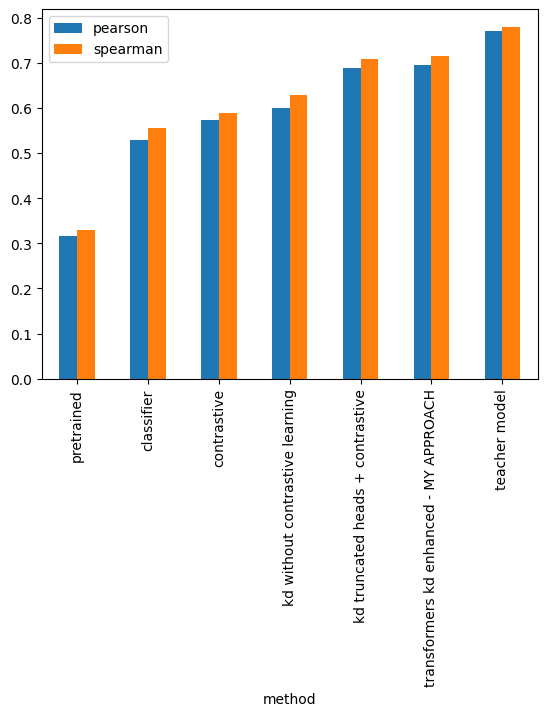

In [ ]:
df_results.sort_values("pearson").plot.bar(x="method")